In [ ]:
!pip install lightning

In [ ]:
!pip install natasha

In [ ]:
import pandas as pd
import numpy as np
import torchtext
import torch
from torchtext.vocab import build_vocab_from_iterator
from collections import Counter
import natasha
from natasha import Segmenter, Doc
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch
from torch import nn


import torchmetrics
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import ModelSummary
from lightning.pytorch.tuner import Tuner
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks import Callback
import matplotlib.pyplot as plt

from navec import Navec
from slovnet.model.emb import NavecEmbedding

###**Text classification with Word Embeddings**

In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

In [ ]:
csv_file_path = '/content/texts_augmented (translation).csv'
dataframe = pd.read_csv(csv_file_path, sep=';', encoding="cp1251")
dataframe.loc[:, "Style"] = dataframe.loc[:, "Style"].astype('category').cat.codes

In [ ]:
X_text = dataframe.iloc[:, 0].values
y_targets = dataframe.iloc[:, 1].values

In [ ]:
# Texts to lower
X_text = [text.lower() for text in X_text]

In [ ]:
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [ ]:
def maxTextLen(X_text, navec):
  segmenter = Segmenter()
  text_lens = []
  for text in X_text:
    doc = Doc(text)
    doc.segment(segmenter)
    text_tokens = [token.text for token in doc.tokens if token.text in navec]
    text_lens.append(len(text_tokens))
  max_text_len = max(text_lens)
  return max_text_len

def textToTensorDataset(X_data, y_data, max_text_len, navec):
  segmenter = Segmenter()
  num_texts = len(X_data)
  texts_tensor = torch.zeros(num_texts, max_text_len + 2).long()
  targets_tensor = torch.tensor(y_data).long()

  for text_i, text in enumerate(X_text):
    doc = Doc(text)
    doc.segment(segmenter)
    text_tokens = [token.text for token in doc.tokens if token.text in navec]
    for token_i, token in enumerate(text_tokens):
        texts_tensor[text_i, token_i + 1] = navec.vocab[token]
  return TensorDataset(texts_tensor, targets_tensor)

In [ ]:
max_text_len = maxTextLen(X_text, navec)
train_dataset = textToTensorDataset(X_text, y_targets, max_text_len, navec)

In [ ]:
class CustomConv1D(nn.Module):
  def __init__(self,
               in_channels:int,
               out_channels:int,
               kernel_size:int,
               dilation:int):
    super().__init__()
    self.conv1d = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=kernel_size//2, dilation=dilation)
    self.activation = nn.LeakyReLU(0.2);

  def forward(self, x):
    x = self.conv1d(x)
    x = self.activation(x)
    return x

In [ ]:
class TokenCNN(nn.Module):
  def __init__(self,
               in_embed_size:int,
               context_embed_size:int):
    super().__init__()
    self.conv_1_1 = CustomConv1D(in_channels=in_embed_size, out_channels=context_embed_size, kernel_size=7, dilation=1)
    self.conv_1_2 = CustomConv1D(in_channels=context_embed_size, out_channels=context_embed_size, kernel_size=3, dilation=1)
    self.pooling_1 = nn.MaxPool1d(kernel_size=3, stride=3)

    self.conv_2_1 = CustomConv1D(in_channels=context_embed_size, out_channels=context_embed_size, kernel_size=7, dilation=1)
    self.conv_2_2 = CustomConv1D(in_channels=context_embed_size, out_channels=context_embed_size, kernel_size=3, dilation=1)
    self.pooling_2 = nn.MaxPool1d(kernel_size=3, stride=3)

    self.conv_3_1 = CustomConv1D(in_channels=context_embed_size, out_channels=context_embed_size, kernel_size=7, dilation=1)
    self.conv_3_2 = CustomConv1D(in_channels=context_embed_size, out_channels=context_embed_size, kernel_size=3, dilation=1)
    self.pooling_3 = nn.MaxPool1d(kernel_size=3, stride=3)

    self.conv_4_1 = CustomConv1D(in_channels=context_embed_size, out_channels=context_embed_size, kernel_size=7, dilation=1)
    self.conv_4_2 = CustomConv1D(in_channels=context_embed_size, out_channels=context_embed_size, kernel_size=3, dilation=1)
    self.pooling_4 = nn.MaxPool1d(kernel_size=3, stride=3)

  def forward(self, x):
    x = self.conv_1_1(x)
    x = x + self.conv_1_2(x)
    x = self.pooling_1(x)

    x = self.conv_2_1(x)
    x = x + self.conv_2_2(x)
    x = self.pooling_2(x)

    x = self.conv_3_1(x)
    x = x + self.conv_3_2(x)
    x = self.pooling_3(x)

    x = self.conv_4_1(x)
    x = x + self.conv_4_2(x)
    x = self.pooling_4(x)
    return x

In [ ]:
class ClassificationHead(nn.Module):
  def __init__(self,
               in_features:int,
               out_features:int,
               dropout:float):
    super().__init__()
    self.dropout = nn.Dropout(dropout)
    self.classifier = nn.Linear(in_features=in_features, out_features=out_features)

  def forward(self, x):
    x = self.dropout(x)
    x = self.classifier(x)
    return x

In [ ]:
class Network(nn.Module):
    def __init__(self,
                 num_classes,
                 max_text_len,
                 token_embedding_size=256,
                 classifier_dropout=0.5):
        super().__init__()
        self.embeddings = NavecEmbedding(navec)
        self.token_cnn = TokenCNN(in_embed_size=300, context_embed_size=token_embedding_size)
        self.global_pooling_context = nn.AdaptiveMaxPool1d(1)
        self.classification_head = ClassificationHead(in_features=token_embedding_size, out_features=num_classes, dropout=classifier_dropout)

    def forward(self, tokens):
        batch_size, max_text_len = tokens.shape            # BatchSize x MaxTextLen

        word_embeddings = self.embeddings(tokens)          # BatchSize x MaxTokenLen x EmbSize
        word_embeddings = word_embeddings.permute(0, 2, 1) # BatchSize x EmbSize x MaxTextLen

        context_features = self.token_cnn(word_embeddings)                         # BatchSize x EmbSize x MaxTextLen
        text_features = self.global_pooling_context(context_features).squeeze(-1)  # BatchSize x EmbSize
        logits = self.classification_head(text_features)                           # BatchSize x num_classes
        return logits

In [ ]:
class DataModule(pl.LightningDataModule):
  def __init__(self,
               tensor_dataset,
               batch_size):
    super().__init__()
    self.tensor_dataset = tensor_dataset
    self.batch_size = batch_size
    self.prepare_data()

  def setup(self, stage=None):
    train_size = int(0.8 * len(self.tensor_dataset))
    val_size = len(self.tensor_dataset) - train_size
    self.train_data, self.val_data = random_split(self.tensor_dataset, [train_size, val_size])
    return self.train_data, self.val_data

  def train_dataloader(self):
    return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True, num_workers=2)

  def val_dataloader(self):
    return DataLoader(self.val_data, batch_size=self.batch_size, shuffle = False, num_workers=2)

In [ ]:
class ModelCompilation(pl.LightningModule):
    def __init__(self,
                 model:torch.nn.Module,
                 metrics:dict,
                 loss_function,
                 optimizer:torch.optim,
                 learning_rate:float):
        super().__init__()
        self.model = model
        self.metrics = metrics
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.save_hyperparameters(logger=False)

    def forward(self, x):
        pred = self.model.forward(x)
        return pred

    def configure_optimizers(self):
        train_optimizer = self.optimizer(self.parameters(), lr=self.learning_rate, weight_decay=0.05, betas = (0.9, 0.98), eps = 1.0e-9)
        train_scheduler = {
            "scheduler": ReduceLROnPlateau(optimizer=train_optimizer, mode="min", factor=0.1, patience=1, min_lr=5e-6),
            "interval": "epoch",
            "frequency": 1,
            "monitor": "val_loss",
        }
        return [train_optimizer], [train_scheduler]

    def training_step(self, batch, batch_idx):
        loss, pred, y = self.common_step(batch, batch_idx, 'train')
        return loss

    def validation_step(self, batch, batch_idx):
        loss, pred, y = self.common_step(batch, batch_idx, 'val')
        return loss

    def test_step(self, batch, batch_idx):
        loss, pred, y = self.common_step(batch, batch_idx, 'test')
        return loss

    def common_step(self, batch, batch_idx, stage):
        x, y = batch
        pred = self.forward(x)
        loss = self.loss_function(pred, y)
        if (stage == 'test') or (stage == 'val'):
            on_step = False
        else:
            on_step = True

        [self.log(stage + '_' + metric_name, metric(pred, y).to(device), on_step=on_step, on_epoch=True, prog_bar=True, logger=True) for metric_name, metric in self.metrics.items()]
        self.log(stage + '_' + 'loss', loss, on_step=on_step, on_epoch=True, prog_bar=True, logger=True)
        return loss, pred, y

In [ ]:
class History(Callback):
    def __init__(self):
        self.history = {'val_loss': np.array([]), 'val_accuracy': np.array([]), 'train_loss_epoch' : np.array([]), 'train_accuracy_epoch' : np.array([])}

    def on_train_epoch_end(self, trainer, module):
        logs = trainer.logged_metrics
        self.history['train_loss_epoch'] = np.append(self.history['train_loss_epoch'], logs['train_loss_epoch'].cpu())
        self.history['val_loss'] = np.append(self.history['val_loss'], logs['val_loss'].cpu())
        self.history['train_accuracy_epoch'] = np.append(self.history['train_accuracy_epoch'], logs['train_accuracy_epoch'].cpu())
        self.history['val_accuracy'] = np.append(self.history['val_accuracy'], logs['val_accuracy'].cpu())

In [ ]:
def fit(iteration):
  num_classes = 5
  task = 'multiclass'
  network = Network(num_classes=num_classes,
                    max_text_len=max_text_len,
                    token_embedding_size=256,
                    classifier_dropout=0.5
                    )

  metrics = {'accuracy': torchmetrics.Accuracy(task=task, num_classes=num_classes).to(device)}
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW
  learning_rate = 0.0005

  earlystopping_callback = EarlyStopping(monitor="val_loss", mode="min", patience=5)
  checkpoint_callback = ModelCheckpoint(monitor='val_loss', filename='model-{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}')
  history_callback = History()

  model = ModelCompilation(network, metrics, loss_function, optimizer, learning_rate)
  trainer = pl.Trainer(callbacks=[earlystopping_callback, history_callback, checkpoint_callback], precision='32', accelerator=device, devices=1, max_epochs=50)

  trainer.fit(model, datamodule=data_module)
  print("Best model score for iteration " + str(iteration) + " : " + str(checkpoint_callback.best_model_score))
  return checkpoint_callback, history_callback

In [ ]:
device = 'cpu'
trials = 5
best_score = 100
best_model_path = ''
data_module = DataModule(tensor_dataset=train_dataset, batch_size=8)
for i in range(trials):
  checkpoint, history = fit(i)
  if(checkpoint.best_model_score < best_score):
    best_score = checkpoint.best_model_score
    best_model_path = checkpoint.best_model_path
    best_history = history

print("Best model score for " + str(trials) + " trials: " + str(best_score))
print("Best model path: " + best_model_path)

In [ ]:
def plot_train_metrics(history_callback):
  plt.figure()
  plt.plot(list(range(len(history_callback.history['train_loss_epoch']))), history_callback.history['train_loss_epoch'])
  plt.plot(list(range(len(history_callback.history['val_loss']))), history_callback.history['val_loss'])
  plt.legend(['train_loss', 'val_loss'])

  plt.figure()
  plt.plot(list(range(len(history_callback.history['train_accuracy_epoch']))), history_callback.history['train_accuracy_epoch'])
  plt.plot(list(range(len(history_callback.history['val_accuracy']))), history_callback.history['val_accuracy'])
  plt.legend(['train_accuracy', 'val_accuracy'])
  plt.show()

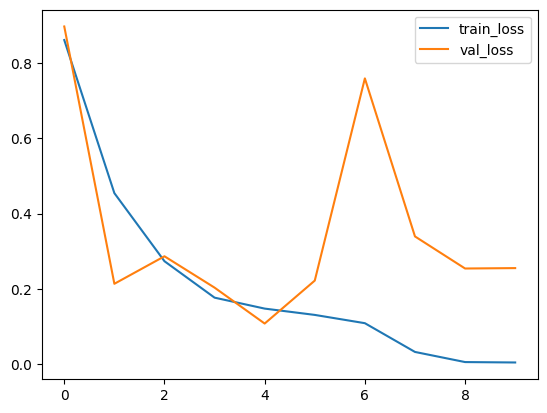

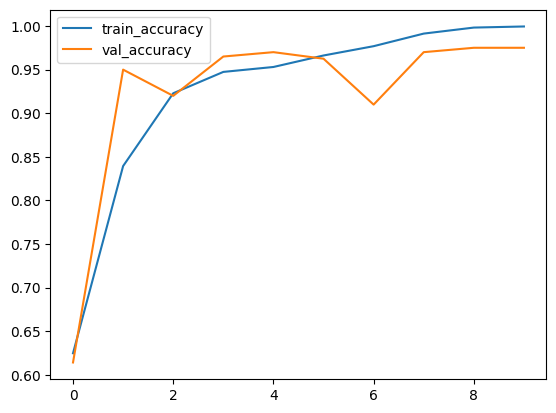

In [ ]:
plot_train_metrics(best_history)

In [ ]:
def load_pretrained_model(checkpoint_path):
  num_classes = 5
  task = 'multiclass'
  network = Network(num_classes=num_classes,
                    max_text_len=max_text_len,
                    token_embedding_size=256,
                    classifier_dropout=0.5
                    )

  metrics = {'accuracy': torchmetrics.Accuracy(task=task, num_classes=num_classes).to(device)}
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW
  learning_rate = 0.0005

  model = ModelCompilation(network, metrics, loss_function, optimizer, learning_rate)
  model = model.load_from_checkpoint(checkpoint_path)
  return model

In [ ]:
def predictStyleForText(text, model, navec, max_text_len):
  texts_tensor = torch.zeros(1, max_text_len + 2).long()
  text = text.lower()
  segmenter = Segmenter()
  doc = Doc(text)
  doc.segment(segmenter)
  text_tokens = [token.text for token in doc.tokens if token.text in navec]
  for token_i, token in enumerate(text_tokens):
      texts_tensor[0][token_i + 1] = navec.vocab[token]

  model.eval()
  logits = model.forward(texts_tensor)
  proba = torch.nn.functional.softmax(logits.data, dim=1)
  return proba